In [1]:
#Read in standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [2]:
#read in ML packages/modules
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
#Read in dask package and set up to allow for faster compute times. Distributes computing among all availabel preocessors
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:59327" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:59344, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:59347, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:59348, threads: 2>})

### Compare Model Accuracies

Let's take a look at all our models to see which one was able to achieve the best accuracy both before and after tuning.

In [4]:
#Read in all score dataframes from other notebooks
scores_list = os.listdir('DFs/scores')
score_df=pd.DataFrame()
for score in scores_list:
    df = pd.read_pickle(r'DFs/scores/{score}'.format(score=score))
    score_df = pd.concat([score_df, df], join='outer')
#score_df.index.rename('Model', inplace=True)
score_df

,model,par,MAPE,MAE,base_estimator,learning_rate,loss,n_estimators,random_state,base_estimator__objective,...,missing,monotone_constraints,num_parallel_tree,reg_alpha,reg_lambda,scale_pos_weight,subsample,tree_method,validate_parameters,verbosity
0,ADA,8,0.386962,2.106786,None,1.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADA,11,0.323358,1.750690,None,1.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADA,34,0.360083,1.650912,None,1.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADA,6,0.386063,1.798488,None,1.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADA,4,0.560456,2.062652,None,1.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,XGB250_LIN,8,0.292802,1.852961,NaN,0.5,NaN,250.0,0,NaN,...,NaN,None,NaN,0.0,0.0,1.0,NaN,None,1.0,None
16,XGB250_LIN,11,0.252206,1.651298,NaN,0.5,NaN,250.0,0,NaN,...,NaN,None,NaN,0.0,0.0,1.0,NaN,None,1.0,None
17,XGB250_LIN,34,0.241635,1.319128,NaN,0.5,NaN,250.0,0,NaN,...,NaN,None,NaN,0.0,0.0,1.0,NaN,None,1.0,None
18,XGB250_LIN,6,0.230570,1.283420,NaN,0.5,NaN,250.0,0,NaN,...,NaN,None,NaN,0.0,0.0,1.0,NaN,None,1.0,None


In [5]:
model_scores = score_df.groupby('model')[['MAPE', 'MAE']].mean()

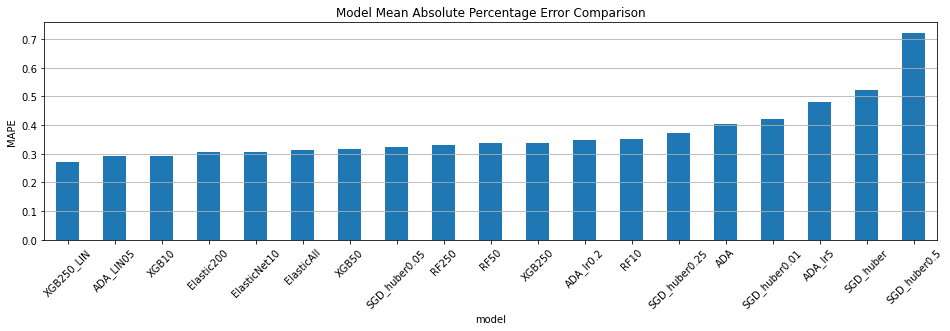

In [6]:
#Plot the accuracies from worst to best going left to right
plt.figure(figsize=(16, 6))
model_scores.sort_values('MAPE')['MAPE'].plot(kind='bar', figsize=(16, 4))
plt.ylabel('MAPE')
plt.title('Model Mean Absolute Percentage Error Comparison')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

There is a good mix of different models on both ends of the spectrum. XGBoost using a linear booster has the best average performance. The ADAboost model using our XGBoost winner is second and ElasticNet is in third. Linear models definitely seem to be perfoming consistenly better than tree based so any future parameter tuning should focus there first. The biggest advantage tree based methods seemed to have was a higher sensitivity to the amplitude of the truths.

Let's take a look at MAE to see if there are any major differences in ordering. While we are averageing participants together we shouldn't have a great difference, but when we split them out futher down, we may.

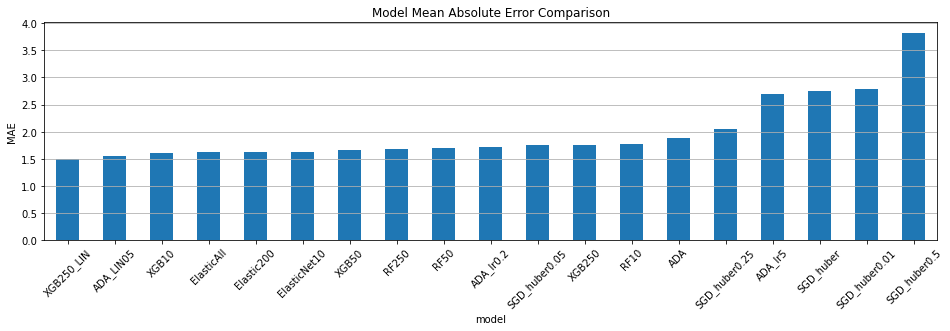

In [7]:
#Plot the accuracies from worst to best going left to right
plt.figure(figsize=(16, 6))
model_scores.sort_values('MAE')['MAE'].plot(kind='bar', figsize=(16, 4))
plt.ylabel('MAE')
plt.title('Model Mean Absolute Error Comparison')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

As expected this follows nearly the same ordering of the MAPE metric visual above. Let's take a look at each models max and min score on individual particpants.

In [8]:
model_scores_min = score_df.groupby('model')[['MAPE', 'MAE']].min()
model_scores_max = score_df.groupby('model')[['MAPE', 'MAE']].max()
model_scores_hl = model_scores_min.merge(model_scores_max, on='model', suffixes=['min', 'max'])
model_scores_hl

,MAPEmin,MAEmin,MAPEmax,MAEmax
model,,,,
ADA,0.323358,1.650912,0.560456,2.106786
ADA_LIN05,0.244721,1.342496,0.360512,1.877702
ADA_lr0.2,0.290144,1.446115,0.475512,2.079701
ADA_lr5,0.376432,2.174672,0.626544,3.540227
Elastic200,0.256528,1.371651,0.361276,2.136065
ElasticAll,0.259873,1.346034,0.376798,2.159317
ElasticNet10,0.256528,1.371651,0.361276,2.136065
RF10,0.271668,1.437698,0.482703,2.114950
RF250,0.255148,1.372785,0.468878,2.067781


<Figure size 1152x432 with 0 Axes>

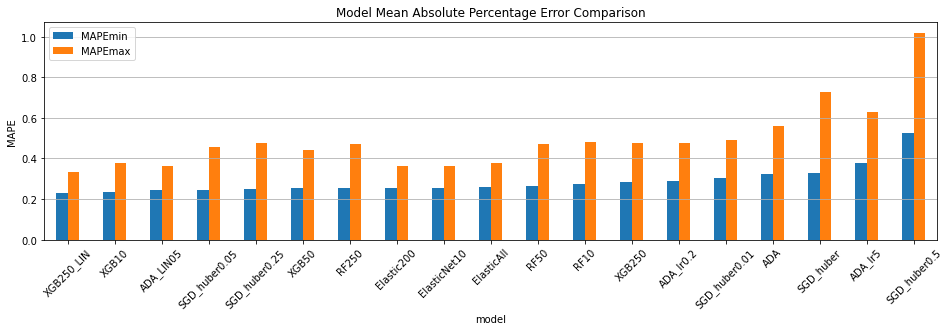

In [9]:
#Plot the accuracies from worst to best going left to right
a = model_scores_hl.sort_values('MAPEmin')
plt.figure(figsize=(16, 6))
a[['MAPEmin', 'MAPEmax']].plot(kind='bar', figsize=(16, 4), label='Best')
plt.ylabel('MAPE')
plt.title('Model Mean Absolute Percentage Error Comparison')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

Not much change accept for the SGD Regressors hopping over the ElasticNet models. This visual is more about curiosity than data to use to correct the model as the average metric is much more telling of our models performance. Let's plot each of the models performances on each of the models.

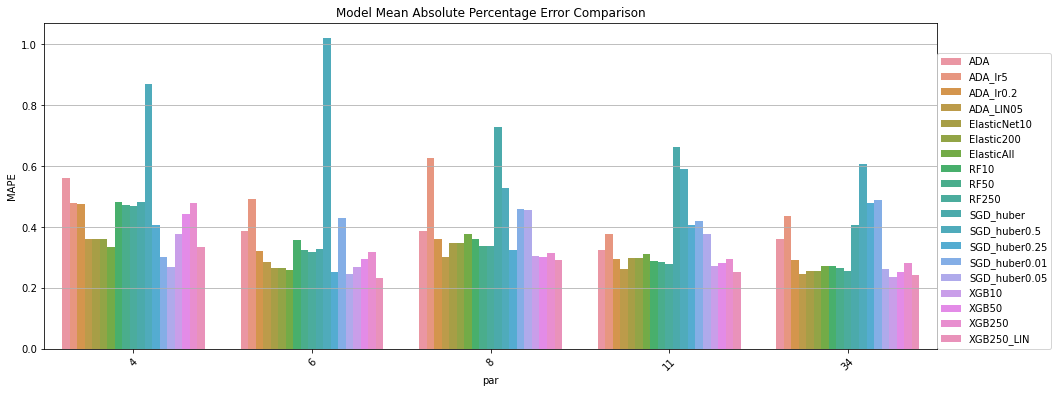

In [11]:
plt.figure(figsize=(16, 6))
sns.barplot(data=score_df, x='par', y='MAPE', hue='model')
plt.ylabel('MAPE')
plt.title('Model Mean Absolute Percentage Error Comparison')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.legend(loc=(1,0))
plt.show()

This visual is good for noting how consistent XGBoost was as it appears to have the best average scores on all but on participant. ElasticNet all consistently perfomred well as did SGDRegressor with 0.05 learning rate, which shows the power of hyperparameter tuning.

In [29]:
for par in score_df['par'].unique():
    print('{} Best Models'.format(par))
    print(score_df.pivot(index='par', columns='model', values='MAPE').sort_values(by=par,axis=1).iloc[:,:5])
    print('\n')

6 Best Models
model  XGB250_LIN  SGD_huber0.05  SGD_huber0.25  ElasticAll  Elastic200
par                                                                    
4        0.332335       0.268708       0.405221    0.333647    0.361276
6        0.230570       0.246767       0.251616    0.259873    0.264813
8        0.292802       0.455997       0.325519    0.376798    0.346239
11       0.252206       0.376883       0.405211    0.311835    0.296571
34       0.241635       0.261265       0.476920    0.273112    0.256528


34 Best Models
model     XGB10  XGB250_LIN  ADA_LIN05     XGB50     RF250
par                                                       
4      0.378077    0.332335   0.360512  0.442413  0.468878
6      0.267067    0.230570   0.285261  0.295148  0.316360
8      0.303315    0.292802   0.302080  0.301351  0.337840
11     0.270660    0.252206   0.260244  0.280823  0.279651
34     0.236541    0.241635   0.244721  0.252976  0.255148


11 Best Models
model  XGB250_LIN  ADA_LIN05     XG

Looks like there was actually one participant who XGB didn't have the best performance with, participant 4. That participant seemed to be the hardest to predict and is worth looking more into. Increasing the training set could help with different participants as could splitting different kinds of participants into different models: high motion vs. low motion, men vs. women, old vs. young, tall vs. short, quick change in motion vs. slow change in motion, etc.. Figuring out what groups move which ways could help to give researches an idea into what types of music have the highest affect on people so we cuold even split this out to only train and test on different music sections one at a time. 

In [12]:
score_df.sort_values(by='MAPE', inplace=True)
score_df.reset_index(inplace=True, drop=True)
score_df.to_csv(r'Reports/Model_Metrics')

In [13]:
score_df

,model,par,MAPE,MAE,base_estimator,learning_rate,loss,n_estimators,random_state,base_estimator__objective,...,missing,monotone_constraints,num_parallel_tree,reg_alpha,reg_lambda,scale_pos_weight,subsample,tree_method,validate_parameters,verbosity
0,XGB250_LIN,6,0.230570,1.283420,NaN,0.5,NaN,250.0,0,NaN,...,NaN,None,NaN,0.0,0.0,1.0,NaN,None,1.0,None
1,XGB10,34,0.236541,1.361361,NaN,0.3,NaN,10.0,0,NaN,...,NaN,(),1.0,0.0,1.0,1.0,1.0,exact,1.0,None
2,XGB250_LIN,34,0.241635,1.319128,NaN,0.5,NaN,250.0,0,NaN,...,NaN,None,NaN,0.0,0.0,1.0,NaN,None,1.0,None
3,ADA_LIN05,34,0.244721,1.342496,XGBRegressor,0.5,linear,50.0,None,reg:squarederror,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SGD_huber0.05,6,0.246767,1.495603,NaN,invscaling,huber,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,ADA_lr5,8,0.626544,3.540227,None,5.0,linear,50.0,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,SGD_huber,11,0.663188,3.357254,NaN,invscaling,huber,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,SGD_huber,8,0.728361,3.585453,NaN,invscaling,huber,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,SGD_huber0.5,4,0.868177,3.507725,NaN,invscaling,huber,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
